# Distribution des naissances dans le temps 

Dans ce carnet est proposée une analyse de la distribution dans le temps des années de naissance de la population retenue, et la mise en évidence de générations.

On met aussi en évidence l'évolution dans le temps des genres

In [84]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

In [85]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile


In [86]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

## SPARQL Query qui récupère les données

On exécute la requête grâce à une fonction de la librairie locale qui réalise la mise en forme

In [87]:
## define SPARQL enpoint
endpoint = "https://ag1gha303ygjmx4r.allegrograph.cloud/repositories/As-de-la-Guerre"

In [88]:
query = """
PREFIX wd:   <http://www.wikidata.org/entity/>
PREFIX wdt:  <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd:  <http://www.w3.org/2001/XMLSchema#>
PREFIX ex:   <http://example.org/schema/>

SELECT ?ace
       (SAMPLE(?label) AS ?aceLabel)
       (SAMPLE(?allegLabel) AS ?allegiance)
       (SAMPLE(?awardDate) AS ?awardDate)
       (SAMPLE(?awardYearRaw) AS ?awardYear)
       (SAMPLE(?awardCountryLabel) AS ?awardCountry)
WHERE {
  GRAPH <https://github.com/samohTDNM/as-ww1/blob/main/docs/wikidata-import.md> {
    ?ace rdfs:label ?label ;
         wdt:P106 wd:Q2095549 ;
         wdt:P945 ?alleg ;
         ex:awardDate ?awardDate .

         FILTER(REGEX(STR(?awardDate), "^[0-9]{4}-[0-9]{2}-[0-9]{2}"))

         
    ?alleg rdfs:label ?allegLabel .
    
    OPTIONAL {
      ?ace wdt:P166 ?award .
      ?award wdt:P17 ?awardCountry .
      ?awardCountry rdfs:label ?awardCountryLabel .
    }
    BIND(xsd:integer(SUBSTR(STR(?awardDate), 1, 4)) AS ?awardYearRaw)
  }
}
GROUP BY ?ace
ORDER BY ?awardYear
"""

In [89]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [90]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

139


[['http://www.wikidata.org/entity/Q22920866',
  'Louis Robert Lebaudy',
  'France',
  '1901-01-01T00:00:00Z',
  '1901',
  'France'],
 ['http://www.wikidata.org/entity/Q942567',
  'Amédée Thubé',
  'France',
  '1912-01-01T00:00:00Z',
  '1912',
  'France'],
 ['http://www.wikidata.org/entity/Q10933676',
  'Henri Brégi',
  'France',
  '1912-04-27T00:00:00Z',
  '1912',
  'France']]

In [91]:
df_awards = pd.DataFrame(r)
df_awards.columns = [
    'personUri',
    'personLabel',
    'allegiance',
    'awardDate',
    'awardYear',
    'awardCountry'
]
df_awards.head()




,personUri,personLabel,allegiance,awardDate,awardYear,awardCountry
0,http://www.wikidata.org/entity/Q22920866,Louis Robert Lebaudy,France,1901-01-01T00:00:00Z,1901,France
1,http://www.wikidata.org/entity/Q942567,Amédée Thubé,France,1912-01-01T00:00:00Z,1912,France
2,http://www.wikidata.org/entity/Q10933676,Henri Brégi,France,1912-04-27T00:00:00Z,1912,France
3,http://www.wikidata.org/entity/Q77139,Robert Ritter von Greim,Germany,1912-03-01T00:00:00Z,1912,
4,http://www.wikidata.org/entity/Q90765,Max Ritter von Müller,German Empire,1914-04-14T00:00:00Z,1914,


In [92]:
df_awards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   personUri     139 non-null    object
 1   personLabel   139 non-null    object
 2   allegiance    139 non-null    object
 3   awardDate     139 non-null    object
 4   awardYear     139 non-null    object
 5   awardCountry  139 non-null    object
dtypes: object(6)
memory usage: 6.6+ KB


### Vérifier les nationalités présentes directement sur la base de données


Voir les requêtes correspondantes dans le [SPARQL notebook qui créé la population](../../sparqlbooks/wikidata_import_population.sparqlbook)

### Ajouter une colonne au DataFrame avec l'allégeance nettoyée et l'origine des awards

In [93]:
# on créer une fonction que l'on peut appliquer aux deux
def clean_country_label(series, mapping):
    return series.str.strip().replace(mapping)

In [94]:
# la fonction, voir autres notebooks
country_clean_map = {
    "Kingdom of Italy": "Italy",
    "Italy": "Italy",
    "United Kingdom of Great Britain and Ireland": "United Kingdom",
    "United Kingdom": "United Kingdom",
    "British Empire": "United Kingdom",
    "Germany": "Germany",
    "German Empire": "Germany",
    "German Reich": "Germany",
    "Nazi Germany": "Germany",
    "Austria-Hungary": "Austria-Hungary",
    "Austria–Hungary": "Austria-Hungary",
    "Austria": "Austria-Hungary",
    "Second Polish Republic": "Poland",
    "Kingdom of Romania": "Romania",
    "Kingdom of Hungary": "Hungary",
    "Hungary": "Hungary",
    "Russian Empire": "Russia",
    "Soviet Union": "Russia",
}

# on applique aux deux
df_awards['allegiance_clean'] = clean_country_label(df_awards['allegiance'], country_clean_map)
df_awards['awardCountry_clean'] = clean_country_label(df_awards['awardCountry'], country_clean_map)



In [95]:

df_awards_allegiance_clean = df_awards.groupby('allegiance_clean').size().reset_index(name='effectif')

df_awards_allegiance_clean = df_awards_allegiance_clean.sort_values('effectif', ascending=False)

print(df_awards_allegiance_clean.head(30))



   allegiance_clean  effectif
5            France        57
14    United States        28
6           Germany        16
13   United Kingdom         9
11           Russia         6
9            Poland         5
0         Australia         5
3            Canada         3
7             Italy         3
4    Czechoslovakia         1
1   Austria-Hungary         1
2            Brazil         1
10          Romania         1
8            Norway         1
12           Sweden         1
15            Wales         1


## Effectifs par année

In [96]:
### On inspecte les valeurs de la colonne 'awardYear' 
# et on observe que le type de données est 'object', ici texte
df_awards['awardYear'].info()


<class 'pandas.core.series.Series'>
RangeIndex: 139 entries, 0 to 138
Series name: awardYear
Non-Null Count  Dtype 
--------------  ----- 
139 non-null    object
dtypes: object(1)
memory usage: 1.2+ KB


In [97]:
### On transforme le type de valeur de la colonne BirthYear
# de objet à entier
df_awards['awardYear'] = df_awards['awardYear'].astype(int)


In [98]:
### On transforme en DataFrame le résultat du regroupement par année
award_years_count = pd.DataFrame(df_awards[df_awards['awardYear'] < 2001].groupby('awardYear').size())\
                        .reset_index(drop=False)
award_years_count.columns = ['year', 'effectif']
award_years_count

,year,effectif
0,1901,1
1,1912,3
2,1914,4
3,1915,5
4,1916,4
...,...,...
58,1986,1
59,1987,1
60,1989,2
61,1997,1


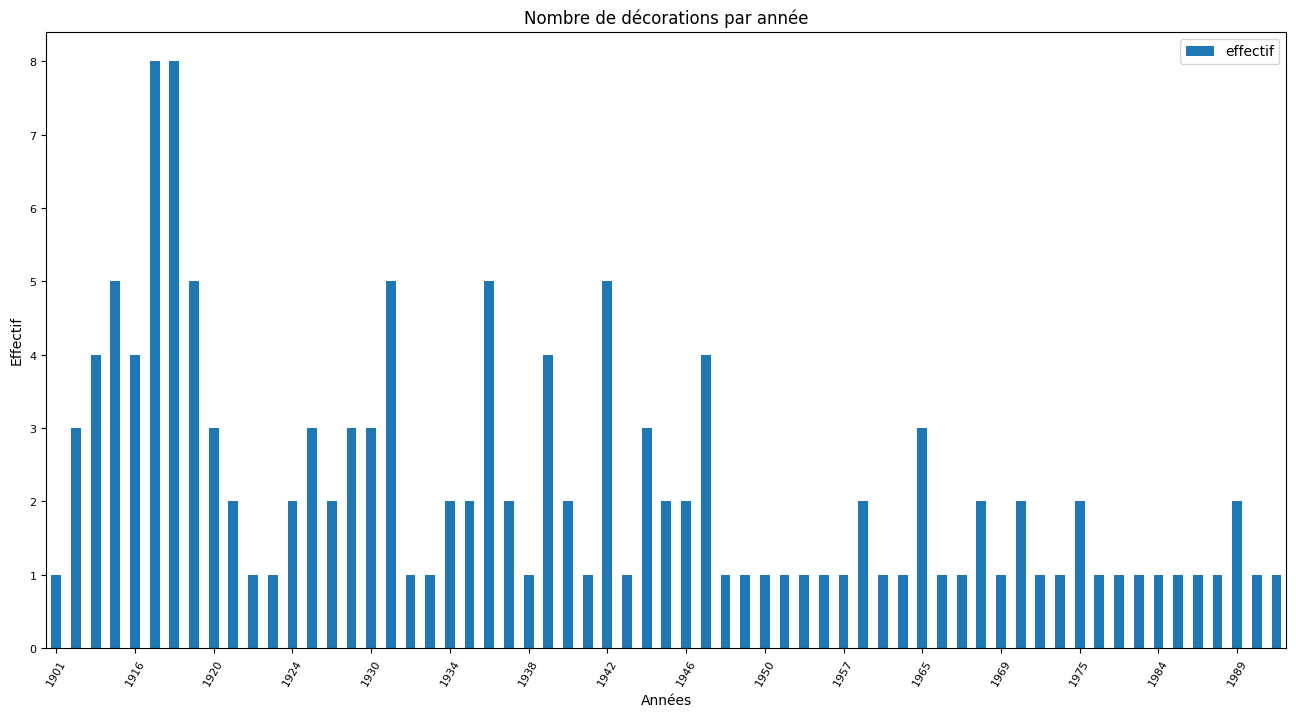

In [99]:
### Représentation graphique des effectifs par année

ax = award_years_count.plot(
    x='year',
    y='effectif',
    kind='bar',
    rot=60,
    fontsize=8,
    figsize=(16, 8)
)

max_xticks = 20
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)

plt.ylabel('Effectif')
plt.xlabel('Années')
plt.title("Nombre de décorations par année")
plt.show()

## Regrouper les effectifs par périodes de 5 ans
Cette étape de facilement distinguer si les awards received de wikidata correspondent majoritairement à des décorations décérnées pendant le conflit ou non. 

In [100]:
### Créer une copie indépendante du DataFrame (attention aux copies de variables qui sont seulement des alias) 
cdf_awards = df_awards[df_awards['awardYear'] < 2001].copy(deep=True)


In [101]:
cdf_awards.head(3)

,personUri,personLabel,allegiance,awardDate,awardYear,awardCountry,allegiance_clean,awardCountry_clean
0,http://www.wikidata.org/entity/Q22920866,Louis Robert Lebaudy,France,1901-01-01T00:00:00Z,1901,France,France,France
1,http://www.wikidata.org/entity/Q942567,Amédée Thubé,France,1912-01-01T00:00:00Z,1912,France,France,France
2,http://www.wikidata.org/entity/Q10933676,Henri Brégi,France,1912-04-27T00:00:00Z,1912,France,France,France


In [102]:
### Année minimale et maximale dans les award dates
print(min(cdf_awards['awardYear']), max(cdf_awards['awardYear']))

1901 1998


### Codage par période de cinq ans

In [103]:
### Créer une liste d'années pour séparer en périodes de 5 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_5 = list(range(1900, 2000, 5))
print(l_5[:5],l_5[-5:])

[1900, 1905, 1910, 1915, 1920] [1975, 1980, 1985, 1990, 1995]


In [104]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

cdf_awards['periodes'] = pd.cut(cdf_awards['awardYear'], l_5, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_awards['periodes'] = cdf_awards['periodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_awards.head(3)

,personUri,personLabel,allegiance,awardDate,awardYear,awardCountry,allegiance_clean,awardCountry_clean,periodes
0,http://www.wikidata.org/entity/Q22920866,Louis Robert Lebaudy,France,1901-01-01T00:00:00Z,1901,France,France,France,1900-1904
1,http://www.wikidata.org/entity/Q942567,Amédée Thubé,France,1912-01-01T00:00:00Z,1912,France,France,France,1910-1914
2,http://www.wikidata.org/entity/Q10933676,Henri Brégi,France,1912-04-27T00:00:00Z,1912,France,France,France,1910-1914


In [105]:
### compter les naissances par périodes de 5 ans
cdf_awards.groupby(by='periodes').size()

C:\Users\menou\AppData\Local\Temp\ipykernel_22868\1798873715.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cdf_awards.groupby(by='periodes').size()


periodes
1900-1904     1
1905-1909     0
1910-1914     7
1915-1919    30
1920-1924     9
1925-1929     8
1930-1934    12
1935-1939    14
1940-1944    12
1945-1949    10
1950-1954     3
1955-1959     4
1960-1964     2
1965-1969     8
1970-1974     4
1975-1979     3
1980-1984     3
1985-1989     5
1990-1994     0
dtype: int64

C:\Users\menou\AppData\Local\Temp\ipykernel_22868\1240986759.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ax = cdf_awards.groupby(by='periodes').size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))


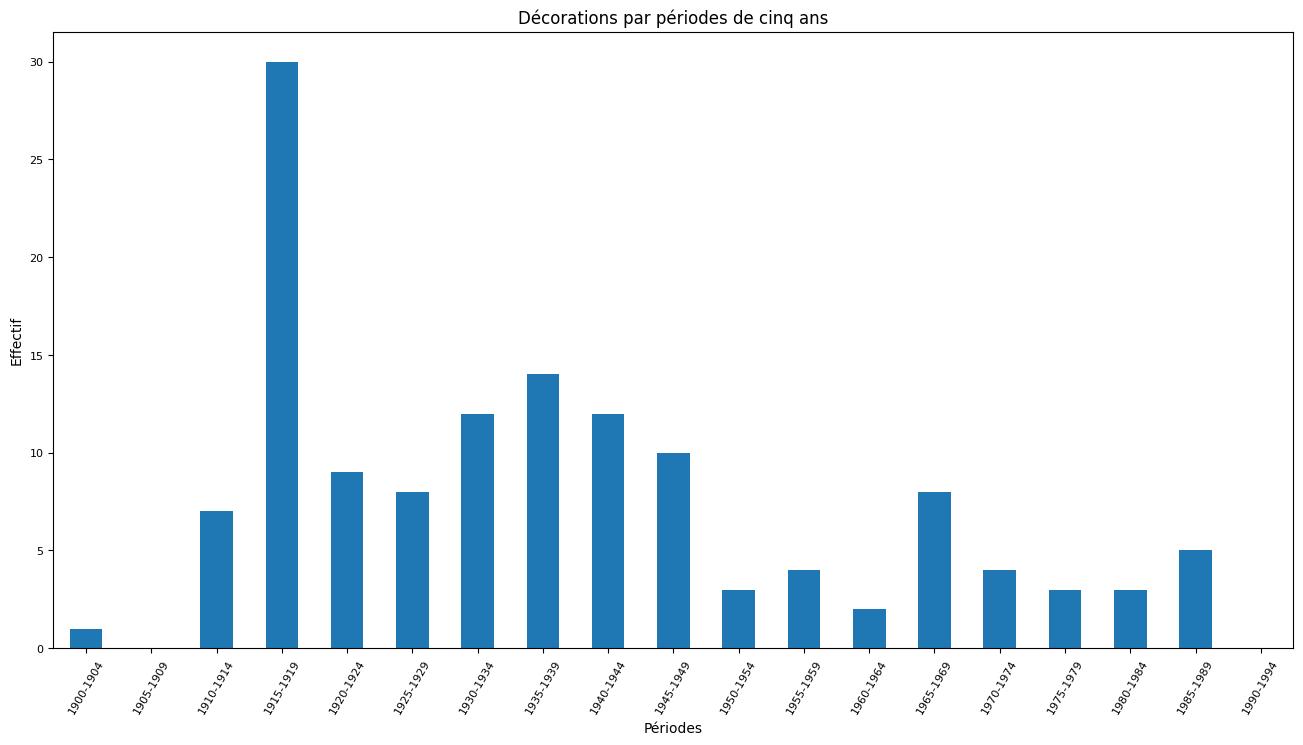

In [106]:
ax = cdf_awards.groupby(by='periodes').size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))
plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Décorations par périodes de cinq ans')
plt.show()

## Ajouter la représentation des nationalités

In [107]:
### Regrouper et compter avec un fitre sur la nationalité française (FR)
country_fr = pd.DataFrame(cdf_awards[cdf_awards['allegiance_clean'] == 'France'].groupby('periodes').size())
country_fr.columns = ['country_fr']
country_fr.tail()



C:\Users\menou\AppData\Local\Temp\ipykernel_22868\679900033.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  country_fr = pd.DataFrame(cdf_awards[cdf_awards['allegiance_clean'] == 'France'].groupby('periodes').size())


,country_fr
periodes,
1970-1974,0
1975-1979,0
1980-1984,2
1985-1989,1
1990-1994,0


In [108]:
### Regrouper et compter les effectifs
top10_allegiances = (
    cdf_awards.groupby('allegiance_clean')
         .size()
         .reset_index(name='effectif')
         .sort_values('effectif', ascending=False)
         .head(10)
)

print(top10_allegiances)

   allegiance_clean  effectif
5            France        56
14    United States        27
6           Germany        16
13   United Kingdom         9
11           Russia         6
9            Poland         5
0         Australia         5
3            Canada         3
7             Italy         3
4    Czechoslovakia         1


In [109]:
# on définit les alliances
def code_alliances(allegiance_clean):
    # Allies during WW1
    allies = {
        "France", "Italy", "United States", "United Kingdom",
        "Australia", "Canada", "New Zealand", "Belgium",
        "Russian Empire", "Russia", "South Africa", "Ireland",
        "Portugal", "Romania", "Serbia"
    }

    # Central Powers during WW1
    central_powers = {
        "Germany", "German Empire", "German Reich", "Nazi Germany",
        "Austria-Hungary", "Austria", "Bulgaria", "Ottoman Empire",
        "Kingdom of Saxony", "Kingdom of Prussia", "Hungary", "Kingdom of Bavaria"
    }

    if allegiance_clean in allies:
        return "Allies"
    elif allegiance_clean in central_powers:
        return "Central Powers"
    else:
        return "Other"

In [110]:
cdf_awards['alliance'] = cdf_awards['allegiance_clean'].apply(code_alliances)


In [111]:
# on regarde la distribution

alliance_counts = (
    cdf_awards['alliance']
    .value_counts()
    .reset_index(name='effectif')
    .rename(columns={'index': 'alliance'})
)

print(alliance_counts)


         alliance  effectif
0          Allies       110
1  Central Powers        17
2           Other        10


In [112]:
# Group by birth decade and alliance
cdf_awards['periodes'] = (cdf_awards['awardYear'] // 5) * 5

merged = (
    cdf_awards.groupby(['periodes', 'alliance'])
    .size()
    .unstack(fill_value=0)
)

merged.index = merged.index.map(str)


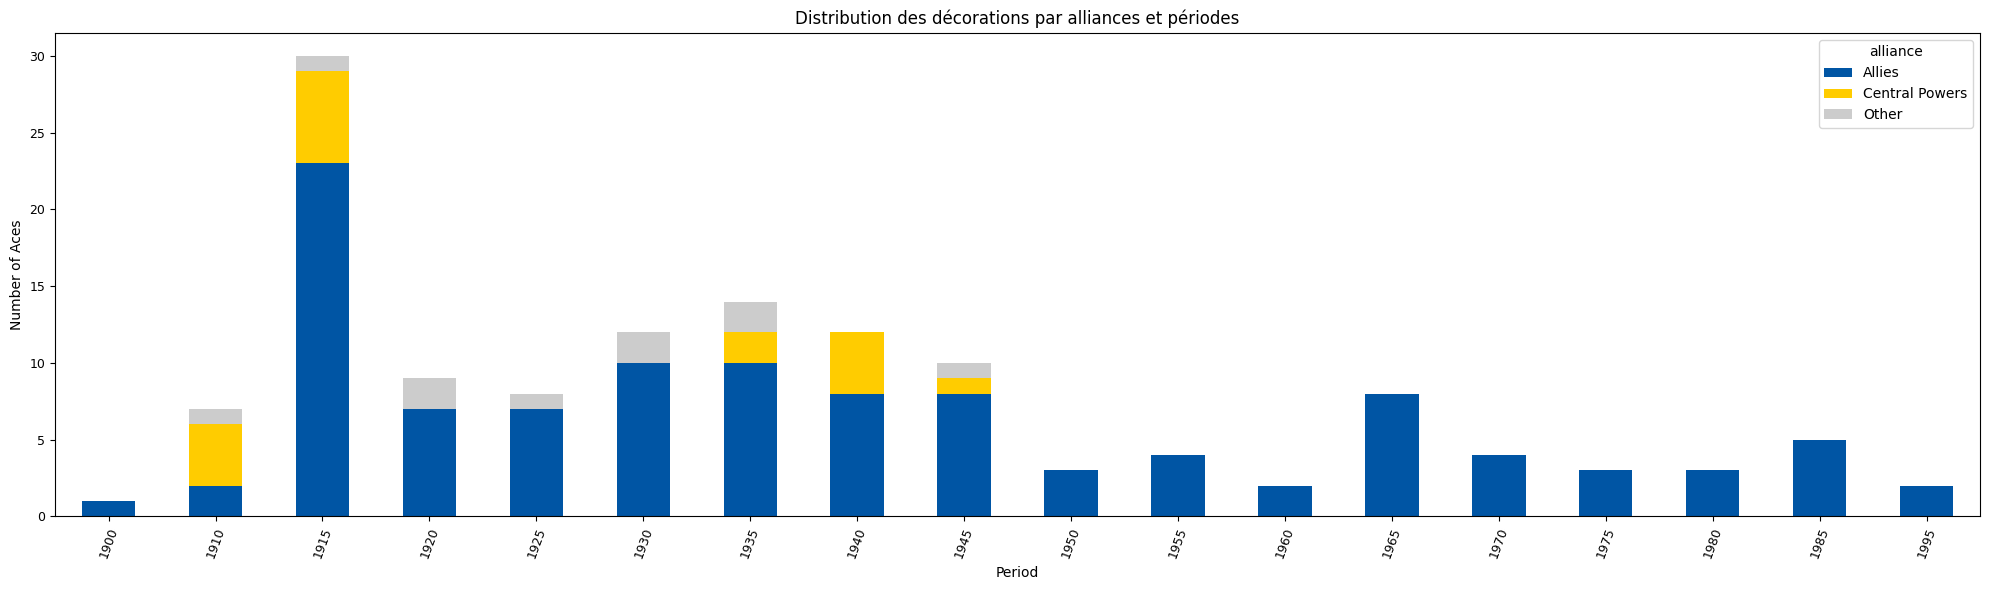

In [113]:
### Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html
ax = merged.plot.bar(
    stacked=True,
    rot=70,
    fontsize=9,
    figsize=(20, 6),
    color=['#0055A4', '#FFCC00', '#CCCCCC'] 
)
plt.title("Distribution des décorations par alliances et périodes")
plt.xlabel("Period")
plt.ylabel("Number of Aces")
plt.tight_layout()
plt.show()

### Codage par période de deux ans

Comme on voit bien dans le graphique précédent qu'il y a une période avec des effectifs importants, 
on restraint la période analysée et on affine avec un découpage par périodes de deux ans 

In [114]:
l_2 = list(range(1900, 2000, 2))
print(l_2[:5],l_2[-5:])

[1900, 1902, 1904, 1906, 1908] [1990, 1992, 1994, 1996, 1998]


In [115]:
### Découpage tous les deux ans
# fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html

cdf_awards['per_2'] = pd.cut(cdf_awards['awardYear'], l_2, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_awards['per_2'] = cdf_awards['per_2'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_awards.head(3)

,personUri,personLabel,allegiance,awardDate,awardYear,awardCountry,allegiance_clean,awardCountry_clean,periodes,alliance,per_2
0,http://www.wikidata.org/entity/Q22920866,Louis Robert Lebaudy,France,1901-01-01T00:00:00Z,1901,France,France,France,1900,Allies,1900-1901
1,http://www.wikidata.org/entity/Q942567,Amédée Thubé,France,1912-01-01T00:00:00Z,1912,France,France,France,1910,Allies,1912-1913
2,http://www.wikidata.org/entity/Q10933676,Henri Brégi,France,1912-04-27T00:00:00Z,1912,France,France,France,1910,Allies,1912-1913


In [116]:
### On regroupe par nationalité comme ci-dessus

allies_2 = pd.DataFrame(
    cdf_awards[(cdf_awards['alliance'] == 'Allies') & (cdf_awards['awardYear'] > 1900)]
    .groupby('per_2')
    .size()
)
allies_2.columns = ['Allies']

allies_2.tail()


C:\Users\menou\AppData\Local\Temp\ipykernel_22868\3436970391.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('per_2')


,Allies
per_2,
1988-1989,2
1990-1991,0
1992-1993,0
1994-1995,0
1996-1997,1


In [117]:
### Idem
central_2 = pd.DataFrame(
    cdf_awards[(cdf_awards['alliance'] == 'Central Powers') & (cdf_awards['awardYear'] > 1900)]
    .groupby('per_2')
    .size()
)
central_2.columns = ['Central Powers']

central_2.tail()


C:\Users\menou\AppData\Local\Temp\ipykernel_22868\4245059960.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('per_2')


,Central Powers
per_2,
1988-1989,0
1990-1991,0
1992-1993,0
1994-1995,0
1996-1997,0


In [118]:
other_2 = pd.DataFrame(
    cdf_awards[(cdf_awards['alliance'] == 'Other') & (cdf_awards['awardYear'] > 1900)]
    .groupby('per_2')
    .size()
)
other_2.columns = ['Other']

other_2.tail()

C:\Users\menou\AppData\Local\Temp\ipykernel_22868\3062974497.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('per_2')


,Other
per_2,
1988-1989,0
1990-1991,0
1992-1993,0
1994-1995,0
1996-1997,0


In [119]:
merged_2 = pd.concat([allies_2, central_2, other_2], axis=1).fillna(0)

merged_2.tail()

,Allies,Central Powers,Other
per_2,,,
1988-1989,2,0,0
1990-1991,0,0,0
1992-1993,0,0,0
1994-1995,0,0,0
1996-1997,1,0,0


In [120]:
### On transforme le type de valeur de l'index
# et on ajoute une colonne avec le total
merged_2.index = merged_2.index.map(str)

merged_2['tot'] = merged_2['Allies'] + merged_2['Central Powers'] + merged_2['Other']
merged_2.tail()

,Allies,Central Powers,Other,tot
per_2,,,,
1988-1989,2,0,0,2
1990-1991,0,0,0,0
1992-1993,0,0,0,0
1994-1995,0,0,0,0
1996-1997,1,0,0,1


In [121]:
### On prépare les valeurs pour l'affichage des fréquences (proportion par rapport au total)

# on regroupe les valeurs
alliances_flat = (
    merged_2['Allies'].tolist() +
    merged_2['Central Powers'].tolist() +
    merged_2['Other'].tolist()
)

totals = merged_2['tot'].tolist() * 3


lp = [round(v / t, 2) if t > 0 else 0 for v, t in zip(alliances_flat, totals)]


print(lp[:6])  

[1.0, 0, 0, 0, 0, 0]


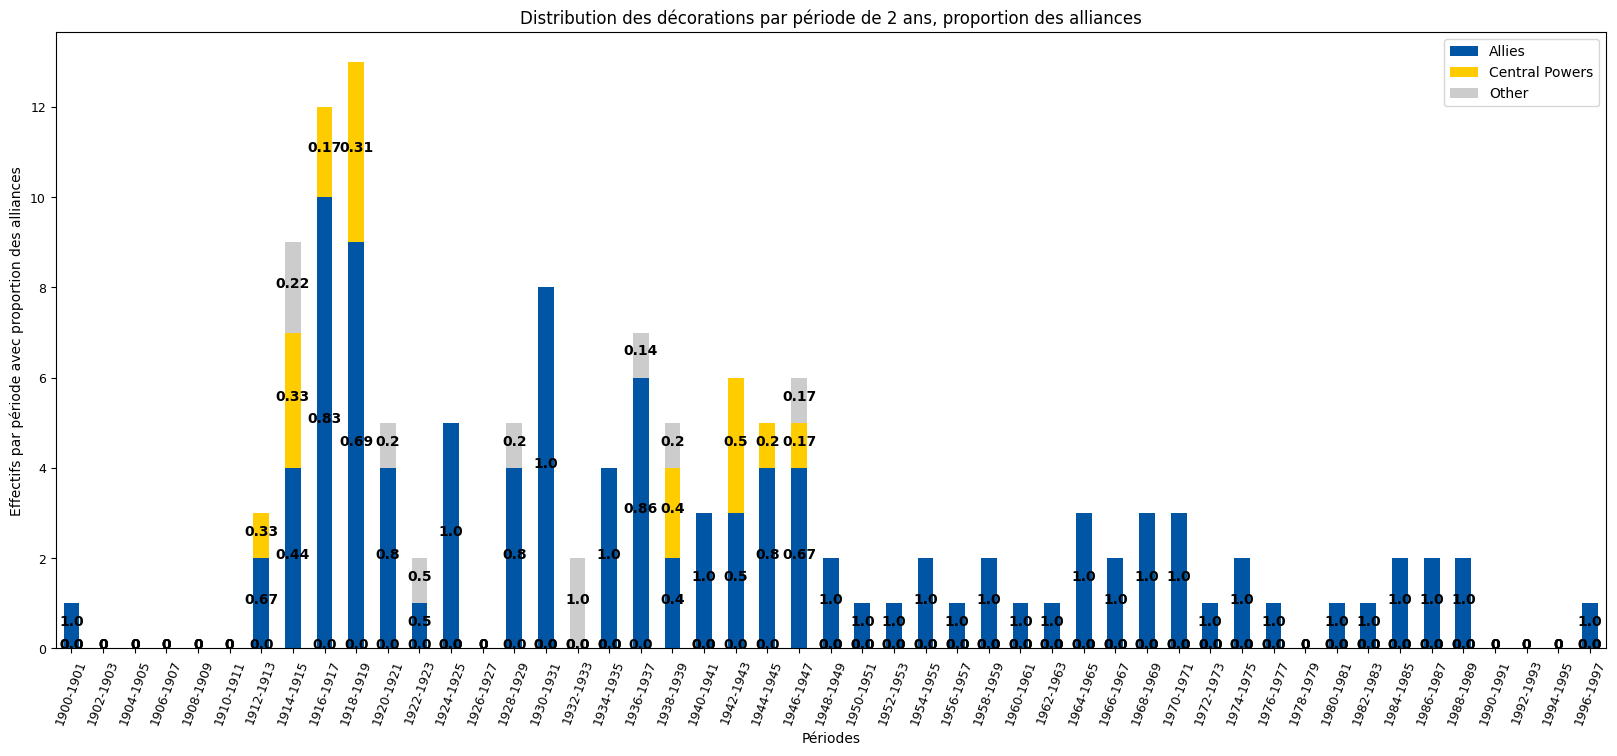

In [122]:
### Graphique avec la distribution (proportion) par période de deux ans et pays

ax = merged_2.plot.bar(
    stacked=True,
    y=['Allies', 'Central Powers', 'Other'],
    rot=70,
    fontsize=9,
    figsize=(20, 8),
    color=['#0055A4', '#FFCC00', '#CCCCCC']  
)

for bar, v in zip(ax.patches, lp): 
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_y() + bar.get_height() / 2,
        v,
        ha='center',
        color='black',
        weight='bold',
        size=10
    )

plt.ylabel('Effectifs par période avec proportion des alliances')
plt.xlabel('Périodes')
plt.title("Distribution des décorations par période de 2 ans, proportion des alliances")


## On peut enregistrer l'image dans un fichier (noter le dossier créé préalablement)
# qu'on pourra ensuite introduire dans un travail et commenter

# Doc.: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html
plt.savefig('naissances_distribution_2ans_pays.jpg', bbox_inches='tight', pad_inches=0.2)
plt.show()

## Analyse des données

In [126]:
# on veut comparer les proportions des périodes de guerre par rapports aux autres
ww1_periods = ["1914-1915", "1916-1917", "1918-1919"]

ww1 = merged_2.loc[merged_2.index.isin(ww1_periods)]
rest = merged_2.loc[~merged_2.index.isin(ww1_periods)]

ww1_total = ww1['tot'].sum()
rest_total = rest['tot'].sum()

total = ww1_total + rest_total
print(f"WW1: {ww1_total} ({ww1_total / total:.2%})")
print(f"Hors WW1: {rest_total} ({rest_total / total:.2%})")


WW1: 34 (25.00%)
Hors WW1: 102 (75.00%)


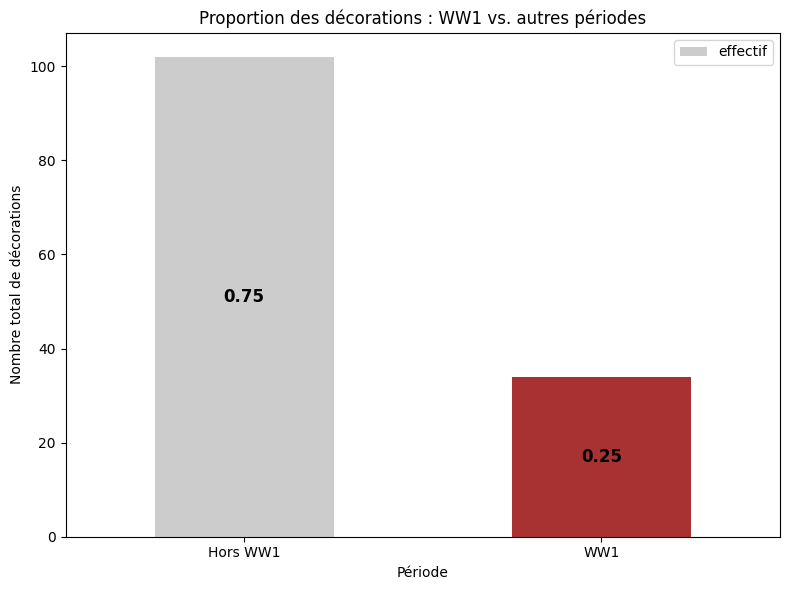

In [128]:
compare_df = pd.DataFrame({
    'période': ['Hors WW1', 'WW1'],
    'effectif': [rest_total, ww1_total]
})

ax = compare_df.plot.bar(
    x='période',
    y='effectif',
    color=['#CCCCCC', '#A83232'],
    rot=0,
    figsize=(8, 6)
)

total_all = rest_total + ww1_total
props = [round(rest_total / total_all, 2), round(ww1_total / total_all, 2)]

for bar, prop in zip(ax.patches, props):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() / 2,
        f"{prop:.2f}",
        ha='center',
        va='center',
        color='black',
        weight='bold',
        size=12
    )

plt.title("Proportion des décorations : WW1 vs. autres périodes")
plt.xlabel("Période")
plt.ylabel("Nombre total de décorations")
plt.tight_layout()
plt.show()


In [134]:
# On compte combien de période les deux catégories comprennent
num_ww1_periods = merged_2.index.isin(ww1_periods).sum()
num_rest_periods = len(merged_2) - num_ww1_periods

total_awards = ww1_total + rest_total
ww1_prop = round(ww1_total / total_awards * 100)
rest_prop = round(rest_total / total_awards * 100)

print(f"Le groupe 'WW1' comprend {num_ww1_periods} périodes de 2 ans et équivaut à {ww1_prop}% des décorations décernées.")
print(f"Le groupe 'Hors WW1' comprend {num_rest_periods} périodes de 2 ans et équivaut à {rest_prop}% des décorations décernées.")


Le groupe 'WW1' comprend 3 périodes de 2 ans et équivaut à 25% des décorations décernées.
Le groupe 'Hors WW1' comprend 46 périodes de 2 ans et équivaut à 75% des décorations décernées.
